## 讀取資料集

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


original : (1141340, 23) (380447, 23)
<br>dropNA : (1131935, 32) (377271, 32)

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_cleaned.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_cleaned.csv')

objList = ['flbmk', 'flg_3dsmk']
for obj in objList:
  test[obj] = (test[obj]=='Y').astype(int)

print(train.shape, test.shape)
print(test.dtypes)

In [ ]:
# drop features
train = train.drop(columns=['conam_log', 'conam_stz','txkey'])
test = test.drop(columns=['conam_log', 'conam_stz','txkey'])

print(train.shape, test.shape)
test.columns

(1131935, 29) (377271, 29)


Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'loctm_morning', 'loctm_afternoon', 'loctm_night',
       'freq_cano', 'freq_bacno', 'conam_equal0'],
      dtype='object')

In [ ]:
# separate X (feature) and y (label) for training data
y_train = train['fraud_ind']
X_train = train.drop(columns=['fraud_ind'])

# separate X (feature) and y (label) for test data
y_test = test['fraud_ind']
X_test = test.drop(columns=['fraud_ind'])

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1131935, 28) (1131935,) (377271, 28) (377271,)


## SMOTE + RFC

In [ ]:
# method 1 --> SMOTE
# 對樣本少的類別進行 Oversampling ，使正、反例為 1:1
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=238)
over_X_train, over_y_train = sm.fit_sample(X_train, y_train)
print()
print("Data size before SMOTE : ", X_train.shape, "Data size after SMOTE : ", over_X_train.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Data size before SMOTE :  (1131935, 31) Data size after SMOTE :  (2233616, 31)


In [ ]:
# 模型訓練 - 隨機森林 : Bagging + Decision tree
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20, max_depth=4)
rfc.fit(over_X_train, over_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# 模型測試，輸出結果
from sklearn.metrics import roc_auc_score, classification_report

y_pred_rfc = rfc.predict(X_test)
print('auc:', roc_auc_score(y_test, y_pred_rfc))

print(classification_report(y_test, y_pred_rfc))

auc: 0.8408938630963141
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    372238
           1       0.19      0.72      0.30      5033

    accuracy                           0.95    377271
   macro avg       0.59      0.84      0.64    377271
weighted avg       0.99      0.95      0.97    377271



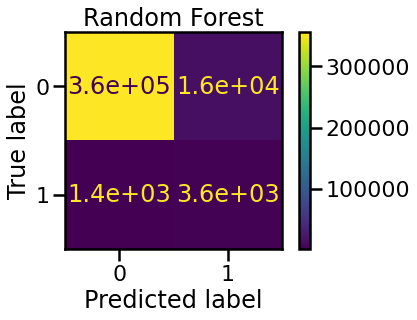

In [ ]:
# 混淆矩陣視覺化
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

sns.set_context("poster")

disp = plot_confusion_matrix(rfc, X_test, y_test)
_ = disp.ax_.set_title("Random Forest")

## BBC

In [ ]:
# method 2 --> BalancedBaggingClassifier
# 訓練一個分類器來處理類別不平衡問題，而不必在訓練前手動進行欠採樣或過採樣
# Under-sample the majority class(es) by randomly picking samples with or without replacement.

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                replacement=True,
                                bootstrap_features=True) 
# 訓練測試
bbc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features='auto',
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                               

In [ ]:
print(X_train.shape, X_test.shape)

(1131935, 29) (377271, 29)


In [ ]:
# 模型測試，輸出結果
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

y_pred = bbc.predict(X_test)
print('auc:', roc_auc_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

auc: 0.9042556125792616
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    372238
           1       0.30      0.84      0.44      5033

    accuracy                           0.97    377271
   macro avg       0.65      0.90      0.71    377271
weighted avg       0.99      0.97      0.98    377271



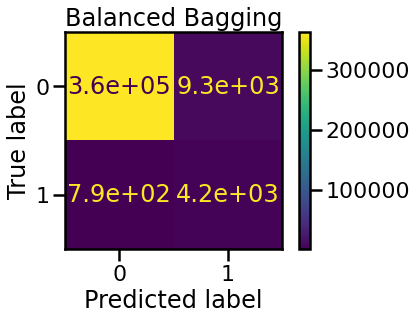

In [ ]:
# 混淆矩陣視覺化
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

sns.set_context("poster")

disp = plot_confusion_matrix(bbc, X_test, y_test)
_ = disp.ax_.set_title("Balanced Bagging")

## 實驗成果視覺化

Balanced Bagging Classifier
[[0.97322412 0.02677588]
 [0.16471289 0.83528711]]


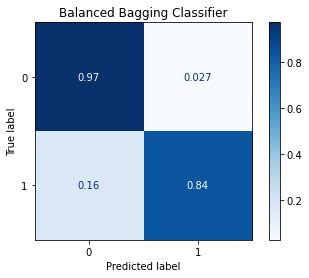

In [ ]:
# 混淆矩陣視覺化
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

titles_options = [#(rfc," SMOTE + Random Forest", 'true'),
                  (bbc,"Balanced Bagging Classifier", 'true')]
for model, title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

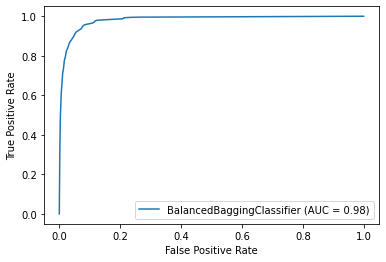

In [ ]:
# 繪製 ROC 曲線
import matplotlib.pyplot as plt
from sklearn import metrics

#metrics.plot_roc_curve(rfc, X_test, y_test)
metrics.plot_roc_curve(bbc, X_test, y_test)
plt.show()

## 輸出檔案 --> 錯誤案例分析

In [ ]:
result = X_test.copy()
print(result.shape)

result['fraud_ind'] = y_test
print(result.shape)

result['predict'] = y_pred
print(result.shape)

result.to_csv('/content/drive/MyDrive/Colab Notebooks/test_withPred.csv',index=False)

362271 9967 829 4204
(377271, 28)
(377271, 29)
(377271, 30)
